## Skinthesia Classification Model

## Import Library

In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:
!pip install --no-build-isolation tensorflowjs

In [1]:
import re
import ast
import json 
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, f1_score, hamming_loss, jaccard_score

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-06-08 14:29:20.534881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


## Load Data

In [2]:
# Load the CSV file
df = pd.read_csv('../data/products_integrated_features.csv', encoding='ISO-8859-1')
df.head()

,url,image,product_name,brand,category,price,rating,skin_type,total_reviews,skin_concern,ingredients,ingredient_category,skin_goal,age,rating_star
0,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/210/images/p...,Acne Gel,Verile,Acne treatment,20000,3.7,"['combination', 'oily']",81477,"['acne', 'blackheads']","['niacinamide', 'licorice, niacinamide', 'niac...","['acne', 'brightening']","['brightening', 'hydrating']",19 - 24,4.343434
1,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/300/remaster...,Acne Patch,Derma Angel,Acne treatment,43000,4.1,"['combination', 'oily']",131694,"['sensitive', 'irritation']","['niacinamide', 'tea tree', 'salicylic acid']","['acne', 'brightening']","['hydrating', 'smoothing']",19 - 24,4.695035
2,https://reviews.femaledaily.com/products/clean...,https://image.femaledaily.com/dyn/210/images/p...,Bright Complete Brightening Face Wash Foam,Garnier,Facial Wash,27000,3.2,"['combination', 'normal']",127058,"['acne', 'redness']","['salicylic acid, vitamin c', 'vitamin c', 'sa...","['acne', 'brightening']","['calming', 'fast-absorbing']",19 - 24,4.316832
3,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/210/images/p...,CL,Benzolac,Acne treatment,32000,3.8,"['combination', 'oily']",22718,"['pores', 'blackheads']","['niacinamide', 'niacinamide, salicylic acid',...","['acne', 'brightening']","['pore-minimizing', 'brightening']",19 - 24,4.405405
4,https://reviews.femaledaily.com/products/treat...,https://image.femaledaily.com/dyn/210/images/p...,Acne Care Lotion,Sariayu,Acne treatment,48000,3.6,"['combination', 'oily']",4998,"['dryness', 'sensitive']","['bha', 'tea tree', 'retinol', 'centella asiat...","['acne', 'calming']","['barrier-repair', 'calming']",25 - 29,4.264706


## Data Selection

In [3]:
# Mengambil kolom yang relevan
df = df[['skin_type','skin_concern','skin_goal','ingredients','ingredient_category']]
df.head()

,skin_type,skin_concern,skin_goal,ingredients,ingredient_category
0,"['combination', 'oily']","['acne', 'blackheads']","['brightening', 'hydrating']","['niacinamide', 'licorice, niacinamide', 'niac...","['acne', 'brightening']"
1,"['combination', 'oily']","['sensitive', 'irritation']","['hydrating', 'smoothing']","['niacinamide', 'tea tree', 'salicylic acid']","['acne', 'brightening']"
2,"['combination', 'normal']","['acne', 'redness']","['calming', 'fast-absorbing']","['salicylic acid, vitamin c', 'vitamin c', 'sa...","['acne', 'brightening']"
3,"['combination', 'oily']","['pores', 'blackheads']","['pore-minimizing', 'brightening']","['niacinamide', 'niacinamide, salicylic acid',...","['acne', 'brightening']"
4,"['combination', 'oily']","['dryness', 'sensitive']","['barrier-repair', 'calming']","['bha', 'tea tree', 'retinol', 'centella asiat...","['acne', 'calming']"


In [4]:
# Information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   skin_type            908 non-null    object
 1   skin_concern         908 non-null    object
 2   skin_goal            908 non-null    object
 3   ingredients          908 non-null    object
 4   ingredient_category  885 non-null    object
dtypes: object(5)
memory usage: 35.6+ KB


## Data Cleaning & Parsing

In [6]:
# Menggunakan ast untuk evaluasi literal
# Fungsi flatten list
def flatten_list(nested_lst):
    flat = []
    for item in nested_lst:
        if isinstance(item, list):
            flat.extend(flatten_list(item))
        else:
            flat.append(item)
    return flat

# Fungsi untuk parsing dan membersihkan data
def parse_and_clean(cell):
    # Cek kalau sudah list langsung pakai
    if isinstance(cell, list):
        lst = cell
    # Kalau string, coba literal_eval ke list Python
    elif isinstance(cell, str):
        try:
            lst = ast.literal_eval(cell)
        except:
            lst = [cell]
    # Tangani nilai NaN
    elif pd.isna(cell):
        return []
    else:
        # Kalau bukan list/string/NaN, jadikan string dalam list
        lst = [str(cell)]

    # Flatten nested list
    flat_list = flatten_list(lst)

    # Split elemen dengan koma
    split_list = []
    for item in flat_list:
        if isinstance(item, str):
            parts = [part.strip() for part in item.split(',')]
            split_list.extend(parts)
        else:
            split_list.append(str(item).strip())

    # Normalisasi dan hapus duplikat
    seen = set()
    result = []
    for item in split_list:
        item_norm = re.sub(r'[\[\]\'\"]', '', item.lower().strip())
        if item_norm and item_norm not in seen:
            seen.add(item_norm)
            result.append(item_norm)

    return result

In [7]:
# Apply the parsing and cleaning function to each column
cols = df.columns
for col in cols:
    df[col] = df[col].apply(parse_and_clean)

df.head()

,skin_type,skin_concern,skin_goal,ingredients,ingredient_category
0,"[combination, oily]","[acne, blackheads]","[brightening, hydrating]","[niacinamide, licorice, salicylic acid]","[acne, brightening]"
1,"[combination, oily]","[sensitive, irritation]","[hydrating, smoothing]","[niacinamide, tea tree, salicylic acid]","[acne, brightening]"
2,"[combination, normal]","[acne, redness]","[calming, fast-absorbing]","[salicylic acid, vitamin c]","[acne, brightening]"
3,"[combination, oily]","[pores, blackheads]","[pore-minimizing, brightening]","[niacinamide, salicylic acid]","[acne, brightening]"
4,"[combination, oily]","[dryness, sensitive]","[barrier-repair, calming]","[bha, tea tree, retinol, centella asiatica]","[acne, calming]"


In [8]:
# Cek berapa banyak list kosong di tiap kolom
for col in df.columns:
    empty_count = df[col].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
    print(f"{col}: {empty_count} list kosong")
print()

# Cek jumlah unknown
total = len(df)
for col in cols:
    count = df[col].apply(lambda x: 'unknown' in x).sum()
    percent = count / total * 100
    print(f"{col}: {count} baris ({percent:.2f}%) mengandung 'unknown'")

skin_type: 0 list kosong
skin_concern: 0 list kosong
skin_goal: 0 list kosong
ingredients: 0 list kosong
ingredient_category: 23 list kosong

skin_type: 0 baris (0.00%) mengandung 'unknown'
skin_concern: 0 baris (0.00%) mengandung 'unknown'
skin_goal: 0 baris (0.00%) mengandung 'unknown'
ingredients: 73 baris (8.04%) mengandung 'unknown'
ingredient_category: 0 baris (0.00%) mengandung 'unknown'


In [9]:
# Hapus baris yang hanya mengandung 'unknown' di kolom ingredients
df_cleaned = df[df['ingredients'].apply(lambda x: x != ['unknown'])].reset_index(drop=True)

# Hapus baris yang nan atau kosong di kolom ingredients category
df_cleaned = df_cleaned[df_cleaned['ingredient_category'].apply(lambda x: isinstance(x, list) and len(x) > 0)].reset_index(drop=True)

df_cleaned.head()

,skin_type,skin_concern,skin_goal,ingredients,ingredient_category
0,"[combination, oily]","[acne, blackheads]","[brightening, hydrating]","[niacinamide, licorice, salicylic acid]","[acne, brightening]"
1,"[combination, oily]","[sensitive, irritation]","[hydrating, smoothing]","[niacinamide, tea tree, salicylic acid]","[acne, brightening]"
2,"[combination, normal]","[acne, redness]","[calming, fast-absorbing]","[salicylic acid, vitamin c]","[acne, brightening]"
3,"[combination, oily]","[pores, blackheads]","[pore-minimizing, brightening]","[niacinamide, salicylic acid]","[acne, brightening]"
4,"[combination, oily]","[dryness, sensitive]","[barrier-repair, calming]","[bha, tea tree, retinol, centella asiatica]","[acne, calming]"


In [10]:
# Cek berapa banyak list kosong di tiap kolom
for col in df_cleaned.columns:
    empty_count = df_cleaned[col].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
    print(f"{col}: {empty_count} list kosong")
print()

# Cek jumlah unknown
total = len(df_cleaned)
for col in cols:
    count = df_cleaned[col].apply(lambda x: 'unknown' in x).sum()
    percent = count / total * 100
    print(f"{col}: {count} baris ({percent:.2f}%) mengandung 'unknown'")

skin_type: 0 list kosong
skin_concern: 0 list kosong
skin_goal: 0 list kosong
ingredients: 0 list kosong
ingredient_category: 0 list kosong

skin_type: 0 baris (0.00%) mengandung 'unknown'
skin_concern: 0 baris (0.00%) mengandung 'unknown'
skin_goal: 0 baris (0.00%) mengandung 'unknown'
ingredients: 0 baris (0.00%) mengandung 'unknown'
ingredient_category: 0 baris (0.00%) mengandung 'unknown'


## Visualisasi Data

In [11]:
# Flatten semua list di kolom ingredients, ingredient_category, skin_type, skin_concern, dan skin_goal
all_ingredients_category = [item for sublist in df_cleaned['ingredient_category'] for item in sublist]
all_ingredients = [item for sublist in df_cleaned['ingredients'] for item in sublist]
all_skin_types = [item for sublist in df_cleaned['skin_type'] for item in sublist]
all_skin_concerns = [item for sublist in df_cleaned['skin_concern'] for item in sublist]
all_skin_goals = [item for sublist in df_cleaned['skin_goal'] for item in sublist]

# Hitung frekuensi kemunculan setiap ingredient category, ingredient, skin type, skin concern, dan skin goal
ingredient_category_counts = Counter(all_ingredients_category)
ingredient_counts = Counter(all_ingredients)
skin_type_counts = Counter(all_skin_types)
skin_concern_counts = Counter(all_skin_concerns)
skin_goal_counts = Counter(all_skin_goals)

# Tampilkan berapa banyak tiap kategori, ingredient, skin type, skin concern, dan skin goal yang unik
print(f"Jumlah unik ingredient categories: {len(ingredient_category_counts)}")
print(f"Jumlah unik ingredients: {len(ingredient_counts)}")
print(f"Jumlah unik skin types: {len(skin_type_counts)}")
print(f"Jumlah unik skin concerns: {len(skin_concern_counts)}")
print(f"Jumlah unik skin goals: {len(skin_goal_counts)}")

Jumlah unik ingredient categories: 6
Jumlah unik ingredients: 21
Jumlah unik skin types: 4
Jumlah unik skin concerns: 15
Jumlah unik skin goals: 20


In [12]:
# Tampilkan jumlah kemunculan tiap kategori, ingredient, skin type, skin concern, dan skin goal
print("\nJumlah kemunculan tiap ingredient category:")
for ingredient_category, count in ingredient_category_counts.items():
    print(f"{ingredient_category}: {count} kali")


Jumlah kemunculan tiap ingredient category:
acne: 89 kali
brightening: 454 kali
calming: 120 kali
exfoliant: 80 kali
hydrating: 383 kali
anti_aging: 59 kali


In [13]:
print("\nJumlah kemunculan tiap ingredient:")
for ingredient, count in ingredient_counts.items():
    print(f"{ingredient}: {count} kali")


Jumlah kemunculan tiap ingredient:
niacinamide: 329 kali
licorice: 69 kali
salicylic acid: 175 kali
tea tree: 126 kali
vitamin c: 256 kali
bha: 230 kali
retinol: 222 kali
centella asiatica: 164 kali
green tea: 96 kali
aha: 226 kali
glycolic acid: 57 kali
aloe vera: 142 kali
glycerin: 309 kali
lactic acid: 54 kali
pha: 69 kali
ceramide: 108 kali
hyaluronic acid: 166 kali
vitamin e: 49 kali
arbutin: 69 kali
zinc: 72 kali
mandelic acid: 9 kali


In [14]:
print("\nJumlah kemunculan tiap skin type:")
for skin_type, count in skin_type_counts.items():
    print(f"{skin_type}: {count} kali")


Jumlah kemunculan tiap skin type:
combination: 820 kali
oily: 595 kali
normal: 105 kali
dry: 147 kali


In [15]:
print("\nJumlah kemunculan tiap skin concern:")
for skin_concern, count in skin_concern_counts.items():
    print(f"{skin_concern}: {count} kali")



Jumlah kemunculan tiap skin concern:
acne: 543 kali
blackheads: 76 kali
sensitive: 345 kali
irritation: 123 kali
redness: 68 kali
pores: 93 kali
dryness: 208 kali
fine lines: 32 kali
wrinkles: 21 kali
oiliness: 58 kali
hyperpigmentation: 7 kali
tiny bumps: 18 kali
dark spots: 20 kali
whiteheads: 3 kali
dull skin: 38 kali


In [16]:
print("\nJumlah kemunculan tiap skin goal:")
for skin_goal, count in skin_goal_counts.items():
    print(f"{skin_goal}: {count} kali")


Jumlah kemunculan tiap skin goal:
brightening: 358 kali
hydrating: 493 kali
smoothing: 48 kali
calming: 274 kali
fast-absorbing: 104 kali
pore-minimizing: 13 kali
barrier-repair: 21 kali
tone-evening: 23 kali
glowing: 57 kali
oil-control: 61 kali
non-comedogenic: 5 kali
nourishing: 24 kali
scar-fading: 27 kali
refreshing: 22 kali
regenerating: 18 kali
plumping: 26 kali
healthy: 10 kali
lightweight: 11 kali
anti-aging: 27 kali
firming: 7 kali


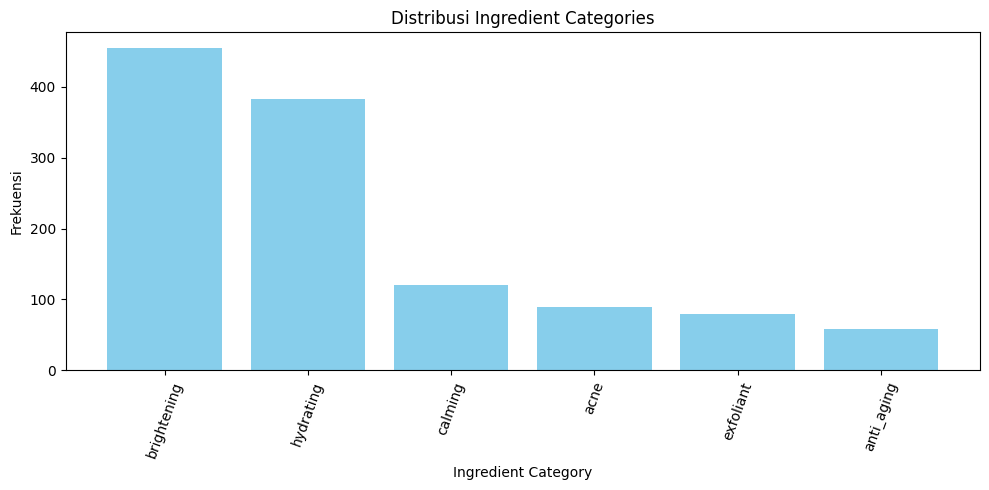

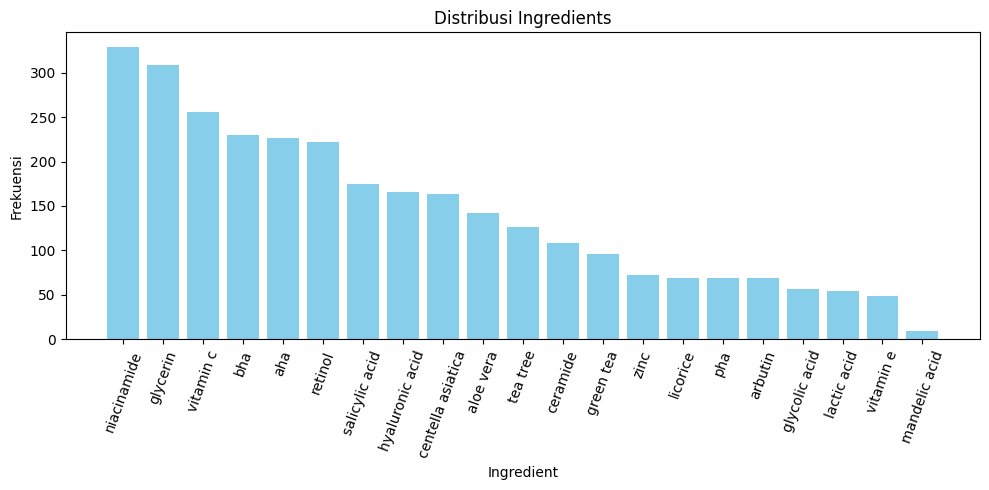

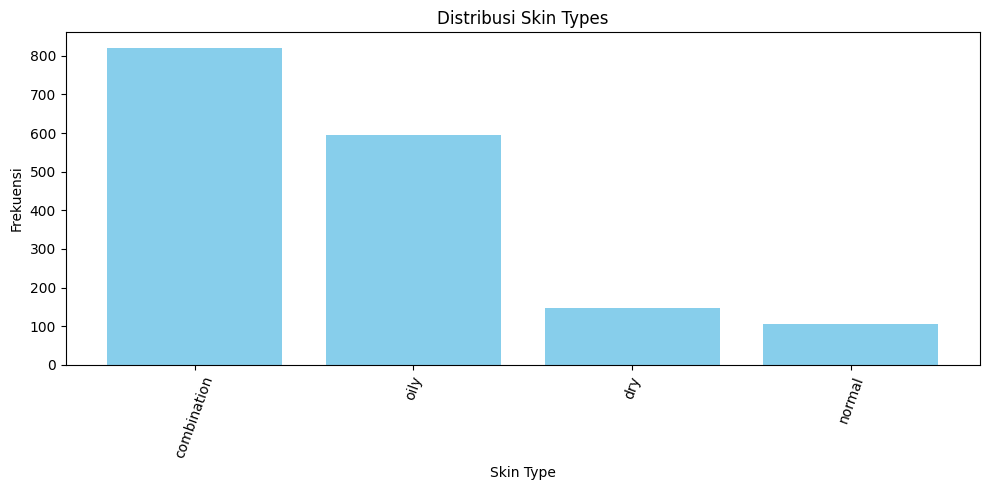

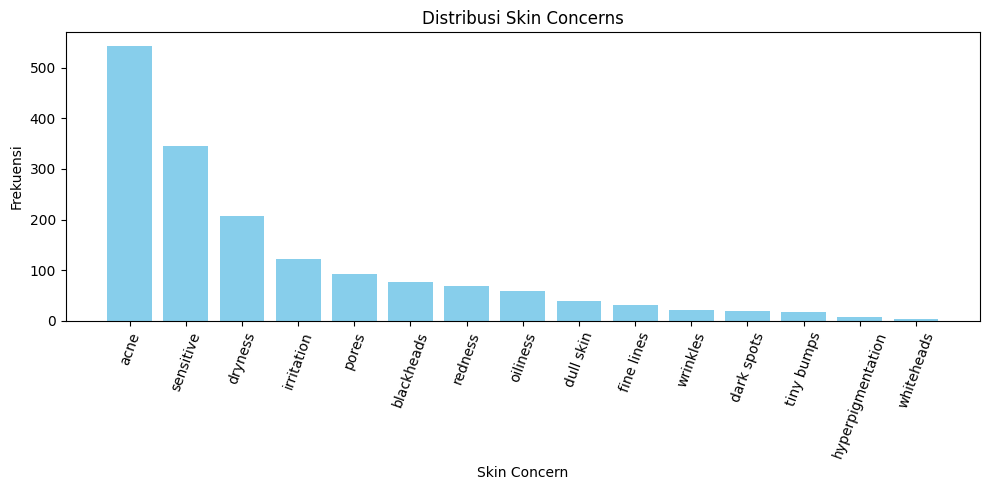

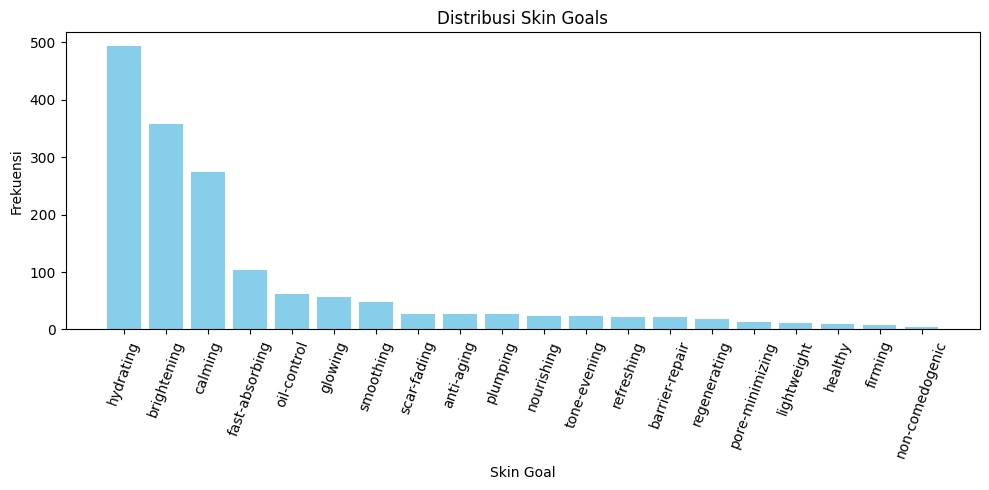

In [18]:
# Visualisasi distribusi skin types, concerns, dan goals
def plot_distribution(data, title, xlabel, ylabel):
    counts = Counter(data)
    # Urutkan berdasarkan nilai (frekuensi), descending
    sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()
    
plot_distribution(all_ingredients_category, 'Distribusi Ingredient Categories', 'Ingredient Category', 'Frekuensi')
plot_distribution(all_ingredients, 'Distribusi Ingredients', 'Ingredient', 'Frekuensi')
plot_distribution(all_skin_types, 'Distribusi Skin Types', 'Skin Type', 'Frekuensi')
plot_distribution(all_skin_concerns, 'Distribusi Skin Concerns', 'Skin Concern', 'Frekuensi')
plot_distribution(all_skin_goals, 'Distribusi Skin Goals', 'Skin Goal', 'Frekuensi')

## Preprocesing Data & Encoding

In [19]:
# Inisialisasi MultiLabelBinarizer untuk tiap fitur dan label
mlb_skin_type = MultiLabelBinarizer()
mlb_skin_concern = MultiLabelBinarizer()
mlb_skin_goal = MultiLabelBinarizer()
mlb_ingredient = MultiLabelBinarizer()
mlb_ingredients_category = MultiLabelBinarizer()

# Fit-transform fitur input dan label (ubah jadi multi-hot vectors)
X_skin_type = mlb_skin_type.fit_transform(df_cleaned['skin_type'])
X_skin_concern = mlb_skin_concern.fit_transform(df_cleaned['skin_concern'])
X_skin_goal = mlb_skin_goal.fit_transform(df_cleaned['skin_goal'])
X_ingredient = mlb_ingredient.fit_transform(df_cleaned['ingredients'])

# Label ingredients category
Y_ingredient_category = mlb_ingredients_category.fit_transform(df_cleaned['ingredient_category'])

# Gabungkan semua fitur input jadi satu matriks fitur
X = np.hstack([X_skin_type, X_skin_concern, X_skin_goal, X_ingredient])

print("Shape fitur input:", X.shape)
print("Shape label (ingredients):", Y_ingredient_category.shape)

Shape fitur input: (835, 60)
Shape label (ingredients): (835, 6)


## Data Splitting

In [20]:
# Split data jadi train/val/test (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y_ingredient_category, test_size=0.3, random_state=42, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (584, 60), (584, 6)
Validation set: (125, 60), (125, 6)
Test set: (126, 60), (126, 6)


## Data Augmentation

In [21]:
# Hitung jumlah sampel tiap label di y_train (multi-label)
print("Jumlah tiap label di train set:")
label_counts = y_train.sum(axis=0)
label_names = mlb_ingredients_category.classes_

df_label_counts = pd.DataFrame({
    'Ingredient Category': label_names,
    'Count_in_train': label_counts
}).sort_values(by='Count_in_train')

print(df_label_counts)

Jumlah tiap label di train set:
  Ingredient Category  Count_in_train
1          anti_aging              38
4           exfoliant              61
0                acne              64
3             calming              77
5           hydrating             269
2         brightening             320


In [22]:
# Fungsi untuk menghitung jumlah label per sampel
def count_labels_per_sample(y_matrix):
    return y_matrix.sum(axis=1)

# Hitung jumlah label per kategori
label_counts = y_train.sum(axis=0).astype(int)
target_per_label = 300  # target baru
label_total = label_counts.copy()

X_aug = []
y_aug = []

In [23]:
# --- Oversample untuk label minor saja (yang < target_per_label) ---
for i, count in enumerate(label_counts):
    if label_total[i] >= target_per_label:
        continue  # label ini sudah cukup jumlahnya

    gap = target_per_label - label_total[i]
    idx = np.where(y_train[:, i] == 1)[0]
    valid_idx = [j for j in idx if y_train[j].sum() <= 2]

    added = 0
    ptr = 0

    while added < gap and ptr < len(valid_idx) * 100:
        j = valid_idx[ptr % len(valid_idx)]
        new_y = y_train[j].copy()
        label_indices = np.where(new_y == 1)[0]

        if (
            all(label_total[k] < target_per_label for k in label_indices)
            or (len(label_indices) == 1 and label_indices[0] == i)
            or (label_total[i] < 0.5 * target_per_label)
        ):
            X_aug.append(X_train[j])
            y_aug.append(new_y)
            for k in label_indices:
                label_total[k] += 1
            added += 1
        ptr += 1

    print(f"Oversample label '{label_names[i]}' → +{added} data")

# Gabungkan data original + data augmentasi
X_all = np.vstack([X_train] + X_aug)
y_all = np.vstack([y_train] + y_aug)

# Validasi max 2 label per sample
valid_mask = np.sum(y_all, axis=1) <= 2
X_final = X_all[valid_mask]
y_final = y_all[valid_mask]

# Shuffle
X_final, y_final = shuffle(X_final, y_final, random_state=42)

# Print hasil akhir
print("\n✅ Setelah oversampling saja dengan max 2 label per data:")
print("X_final:", X_final.shape)
print("y_final:", y_final.shape)

new_counts = y_final.sum(axis=0)
print("\nDistribusi label baru:")
for i, count in enumerate(new_counts):
    print(f"{label_names[i]}: {int(count)}")

Oversample label 'acne' → +236 data
Oversample label 'anti_aging' → +258 data
Oversample label 'calming' → +104 data
Oversample label 'exfoliant' → +152 data

✅ Setelah oversampling saja dengan max 2 label per data:
X_final: (1334, 60)
y_final: (1334, 6)

Distribusi label baru:
acne: 304
anti_aging: 300
brightening: 344
calming: 300
exfoliant: 300
hydrating: 300


## Modelling Pipeline

In [24]:
# Gunakan hasil augmentasi
input_dim = X_final.shape[1]
output_dim = y_final.shape[1]

# Hitung class weights (inverse frequency) dari y_final
freq = np.sum(y_final, axis=0)
total = y_final.shape[0]
class_weights_np = total / (freq + 1e-6)
class_weights_np = class_weights_np / np.max(class_weights_np)  # Normalisasi
class_weights_tf = tf.constant(class_weights_np, dtype=tf.float32)

print("Class weights:", class_weights_np)

Class weights: [0.98684211 1.         0.87209302 1.         1.         1.        ]


In [25]:
# Loss function dengan class weights
def weighted_binary_crossentropy(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * class_weights_tf + (1 - y_true) * 1.0
    weighted_bce = bce * weight_vector
    return K.mean(weighted_bce)

In [26]:
# Build model
def build_model(input_dim, output_dim, lr=0.001, dropout_rate=0.4): 
    model = Sequential([
        Input(shape=(input_dim,)),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(output_dim, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        loss=weighted_binary_crossentropy,
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

# Model summary
model = build_model(input_dim, output_dim)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,950 (230.27 KB)

 Trainable params: 58,054 (226.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Manual hyperparameter tuning
best_f1 = 0
best_params = {}

for lr in [0.001, 0.0005]:
    for batch_size in [32, 64]:
        print(f"\n==============================================")
        print(f"Training model with lr={lr}, batch_size={batch_size}")
        print(f"==============================================\n")
        
        model = build_model(input_dim, output_dim, lr=lr, dropout_rate=0.3)
        history = model.fit(
            X_final, y_final,
            epochs=50,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop, reduce_lr],
            shuffle=True,
            verbose=1
        )

        # Evaluasi di test set
        y_pred_probs = model.predict(X_test)

        # Cari threshold terbaik per class
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_thresholds = []
        for i in range(output_dim):
            f1_scores = []
            for t in thresholds:
                preds = (y_pred_probs[:, i] > t).astype(int)
                f1 = f1_score(y_test[:, i], preds)
                f1_scores.append(f1)
            best_t = thresholds[np.argmax(f1_scores)]
            best_thresholds.append(best_t)

        print("Best thresholds per class:", best_thresholds)

        y_pred = np.zeros_like(y_pred_probs, dtype=int)
        for i in range(output_dim):
            y_pred[:, i] = (y_pred_probs[:, i] > best_thresholds[i]).astype(int)

        f1_macro = f1_score(y_test, y_pred, average='macro')
        print(f"F1 macro score on test: {f1_macro:.4f}")

        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_params = {'lr': lr, 'batch_size': batch_size, 'thresholds': best_thresholds}
            best_model = model
            best_y_pred = y_pred


Training model with lr=0.001, batch_size=32

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - auc: 0.5617 - binary_accuracy: 0.5338 - loss: 0.8682 - precision: 0.2680 - recall: 0.5577 - val_auc: 0.6890 - val_binary_accuracy: 0.7366 - val_loss: 0.6200 - val_precision: 0.4107 - val_recall: 0.3589 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.7945 - binary_accuracy: 0.6836 - loss: 0.6130 - precision: 0.4025 - recall: 0.7743 - val_auc: 0.7686 - val_binary_accuracy: 0.7728 - val_loss: 0.5690 - val_precision: 0.5018 - val_recall: 0.3918 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - auc: 0.8821 - binary_accuracy: 0.7598 - loss: 0.4936 - precision: 0.4898 - recall: 0.8598 - val_auc: 0.8455 - val_binary_accuracy: 0.8308 - val_loss: 0.5130 - val_precision: 0.7043 - val_recall: 0.4438 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.8076 - loss: 0.4303 - precision

In [39]:
print("\n=== ✅ Best Hyperparameters ===")
print(best_params)
print(f"Best F1 macro score: {best_f1:.4f}")


=== ✅ Best Hyperparameters ===
{'lr': 0.001, 'batch_size': 32, 'thresholds': [0.1, 0.25000000000000006, 0.3500000000000001, 0.15000000000000002, 0.1, 0.5000000000000001]}
Best F1 macro score: 0.7555


## Evaluation

In [40]:
# Evaluasi final model di test set
print("\n🔍 Evaluating final model on test set...")

final_probs = best_model.predict(X_test)
final_pred = np.zeros_like(final_probs, dtype=int)
for i in range(output_dim):
    final_pred[:, i] = (final_probs[:, i] > best_params['thresholds'][i]).astype(int)

print("\n📊 Final classification report:")
print(classification_report(y_test, final_pred, zero_division=0))


🔍 Evaluating final model on test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

📊 Final classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       1.00      0.60      0.75        10
           2       0.83      0.95      0.89        61
           3       0.75      0.60      0.67        20
           4       0.40      0.60      0.48        10
           5       0.87      0.97      0.92        63

   micro avg       0.81      0.87      0.84       182
   macro avg       0.78      0.76      0.76       182
weighted avg       0.82      0.87      0.84       182
 samples avg       0.83      0.87      0.84       182



In [41]:
# Print final metrics
print("\n📈 Final Metrics:")
print("🎯 Accuracy Score (subset accuracy):", accuracy_score(y_test, best_y_pred))
print("🤝 F1 Score (macro):", f1_score(y_test, best_y_pred, average='macro'))
print("🤝 F1 Score (micro):", f1_score(y_test, best_y_pred, average='micro'))
print("🤝 F1 Score (weighted):", f1_score(y_test, best_y_pred, average='weighted'))
print("⚖️ Hamming Loss:", hamming_loss(y_test, best_y_pred))
print("📏 Jaccard Score (samples):", jaccard_score(y_test, best_y_pred, average='samples'))


📈 Final Metrics:
🎯 Accuracy Score (subset accuracy): 0.6984126984126984
🤝 F1 Score (macro): 0.7554649027148023
🤝 F1 Score (micro): 0.8381962864721485
🤝 F1 Score (weighted): 0.8375718362259141
⚖️ Hamming Loss: 0.08068783068783068
📏 Jaccard Score (samples): 0.8015873015873016


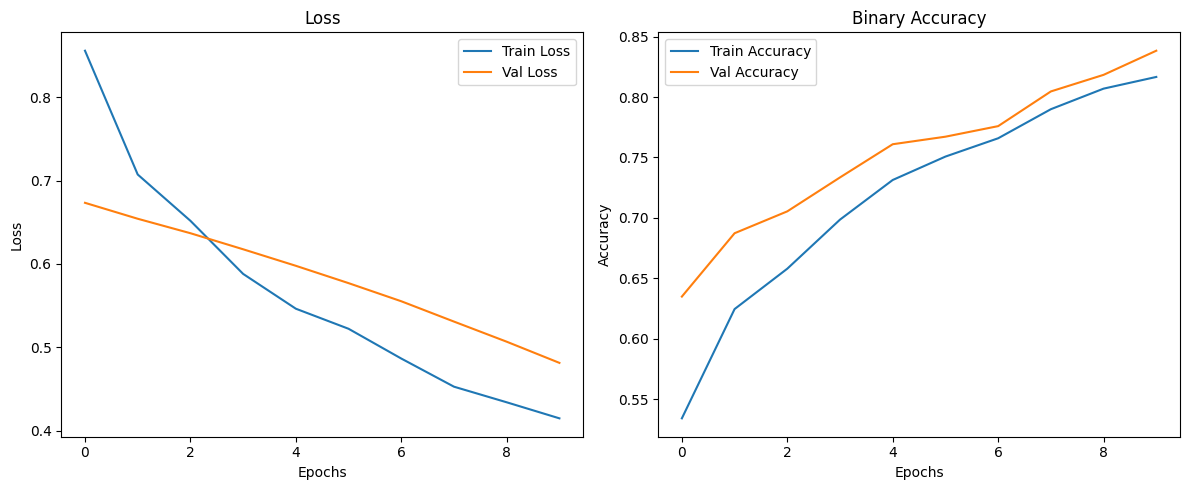

In [42]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
    plt.title('Binary Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Save Model

In [43]:
# Simpan model TensorFlow ke folder models
tfjs.converters.save_keras_model(best_model, '../src/models/model_tfjs')

# Simpan MultiLabelBinarizer ke JSON (bukan pickle)
mlb_classes = {
    'ingredient_category': mlb_ingredients_category.classes_.tolist(),
    'skin_type': mlb_skin_type.classes_.tolist(),
    'skin_concern': mlb_skin_concern.classes_.tolist(),
    'skin_goal': mlb_skin_goal.classes_.tolist(),
    'ingredients': mlb_ingredient.classes_.tolist()
}
with open('../src/models/mlb_classes.json', 'w') as f:
    json.dump(mlb_classes, f, indent=2)

print("Model saved to ../src/models/model_tfjs")
print("MLB classes saved to ../src/models/mlb_classes.json")

failed to lookup keras version from the file,
    this is likely a weight only file
Model saved to ../src/models/model_tfjs
MLB classes saved to ../src/models/mlb_classes.json


## Inference Model

In [50]:
def clean_input(lst):
    if isinstance(lst, str):
        lst = [lst]
    seen = set()
    result = []
    for item in lst:
        item_norm = re.sub(r"[\\[\\]\'\"]", "", item.lower().strip())
        if item_norm and item_norm not in seen:
            seen.add(item_norm)
            result.append(item_norm)
    return result

# --- LOAD MLB CLASSES DARI JSON (BUKAN PICKLE) ---
with open("../src/models/mlb_classes.json", "r") as f:
    mlb_classes = json.load(f)
mlb_skin_type_classes = mlb_classes['skin_type']
mlb_skin_concern_classes = mlb_classes['skin_concern']
mlb_skin_goal_classes = mlb_classes['skin_goal']
mlb_ingredient_classes = mlb_classes['ingredients']
mlb_ingredient_category_classes = mlb_classes['ingredient_category']

# --- FUNGSI UNTUK INFERENCE ---
def predict_ingredient_categories(
    skin_type,
    skin_concern,
    skin_goal,
    ingredient,
    threshold=0.3,
    use_class_thresholds=False,
    best_thresholds=None  # ← tambahkan ini
):
    # Normalisasi input
    skin_type = clean_input(skin_type)
    skin_concern = clean_input(skin_concern)
    skin_goal = clean_input(skin_goal)
    ingredient = clean_input(ingredient)

    # Buat vector multi-hot per fitur
    vec_skin_type = np.array([1 if c in skin_type else 0 for c in mlb_skin_type_classes])
    vec_skin_concern = np.array([1 if c in skin_concern else 0 for c in mlb_skin_concern_classes])
    vec_skin_goal = np.array([1 if c in skin_goal else 0 for c in mlb_skin_goal_classes])
    vec_ingredient = np.array([1 if c in ingredient else 0 for c in mlb_ingredient_classes])

    # Gabungkan semua fitur jadi input vector
    input_vector = np.concatenate([
        vec_skin_type, vec_skin_concern, vec_skin_goal, vec_ingredient
    ]).reshape(1, -1).astype(np.float32)

    # Load model
    model = load_model(
        "../src/models/ingredients_category_classification_model.keras",
        custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy}
    )

    # Prediksi probabilitas
    probs = model.predict(input_vector)[0]

    # Thresholding
    if use_class_thresholds and best_thresholds is not None:
        predicted_labels = [
            label for label, prob, thres in zip(mlb_ingredient_category_classes, probs, best_thresholds)
            if prob >= thres
        ]
    else:
        predicted_labels = [
            label for label, prob in zip(mlb_ingredient_category_classes, probs)
            if prob >= threshold
        ]

    return predicted_labels


In [51]:
# Tes inference
result = predict_ingredient_categories(
    skin_type=['dry'],
    skin_concern=['acne'],
    skin_goal=['hydration'],
    ingredient=['hyaluronic acid'],
    use_class_thresholds=True,
    best_thresholds=best_thresholds
)

print("Rekomendasi Kategori ingredients:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Rekomendasi Kategori ingredients: ['anti_aging', 'calming']
